In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

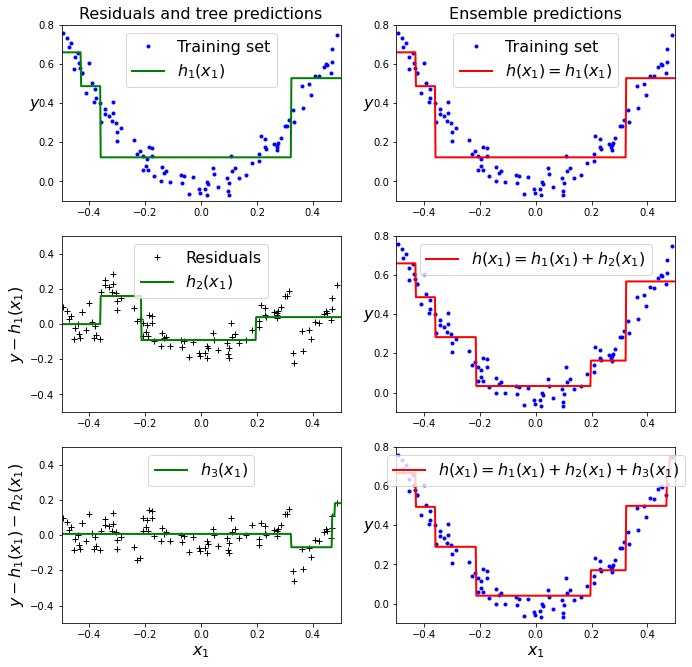

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
df = pd.read_csv('titanic.csv')
df.dropna(inplace=True)
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [11]:
print(df.select_dtypes('category'))

Empty DataFrame
Columns: []
Index: [1, 3, 6, 10, 11, 21, 23, 27, 52, 54, 62, 66, 75, 88, 92, 96, 97, 102, 110, 118, 123, 124, 136, 137, 139, 148, 151, 170, 174, 177, 183, 193, 194, 195, 205, 209, 215, 218, 224, 230, 245, 248, 251, 252, 257, 262, 263, 268, 269, 273, 275, 291, 292, 297, 299, 305, 307, 309, 310, 311, 318, 319, 325, 327, 329, 331, 332, 336, 337, 339, 340, 341, 345, 356, 366, 369, 370, 377, 390, 393, 394, 412, 429, 430, 434, 435, 438, 445, 449, 452, 453, 456, 460, 462, 473, 484, 486, 487, 492, 496, ...]

[183 rows x 0 columns]


In [12]:
columns = ['Pclass', 'Sex', 'Embarked','Survived']
columns_dict = {c:'category' for c in columns}
df = df.astype(columns_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  183 non-null    int64   
 1   Survived     183 non-null    category
 2   Pclass       183 non-null    category
 3   Name         183 non-null    object  
 4   Sex          183 non-null    category
 5   Age          183 non-null    float64 
 6   SibSp        183 non-null    int64   
 7   Parch        183 non-null    int64   
 8   Ticket       183 non-null    object  
 9   Fare         183 non-null    float64 
 10  Cabin        183 non-null    object  
 11  Embarked     183 non-null    category
dtypes: category(4), float64(2), int64(3), object(3)
memory usage: 14.1+ KB


In [13]:
df_dum = pd.get_dummies(df[['Pclass', 'Sex', 'Embarked']])
df_dum.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,0,0,1,0,1,0,0
3,1,0,0,1,0,0,0,1
6,1,0,0,0,1,0,0,1
10,0,0,1,1,0,0,0,1
11,1,0,0,1,0,0,0,1


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [14]:
df = pd.concat([df,df_dum],axis=1)

In [15]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,1,0,0,0,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,0,0,0,1,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [16]:
features = ['Age','Pclass_1', 'Pclass_2','Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S']
X = df[features]
y = df['Survived']

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [17]:
X.shape

(183, 9)

In [18]:
y.shape

(183,)

**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [19]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.fit_transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=0)

In [21]:
X_train.shape

(137, 9)

In [22]:
y_train.shape

(137,)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [23]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.766
Accuracy score (validation): 0.848

Learning rate:  0.1
Accuracy score (training): 0.796
Accuracy score (validation): 0.848

Learning rate:  0.25
Accuracy score (training): 0.803
Accuracy score (validation): 0.848

Learning rate:  0.5
Accuracy score (training): 0.839
Accuracy score (validation): 0.848

Learning rate:  0.75
Accuracy score (training): 0.832
Accuracy score (validation): 0.848

Learning rate:  1
Accuracy score (training): 0.876
Accuracy score (validation): 0.826



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [24]:
gb1 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.75, max_features=2, max_depth = 2, random_state = 0)
gb1.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.75, max_depth=2, max_features=2,
                           n_estimators=20, random_state=0)

**<font color='teal'>Calculate the ROC for the model as well.</font>**

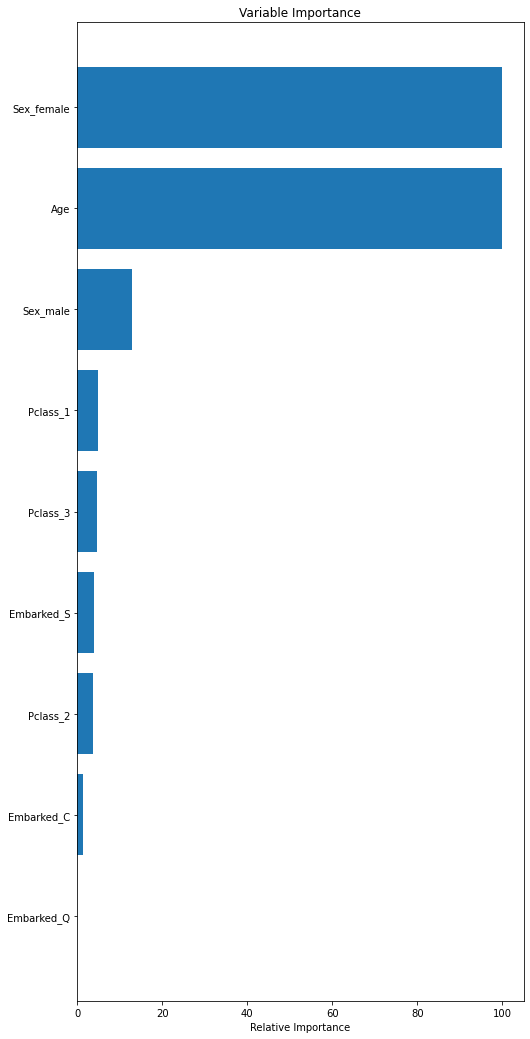

In [25]:
feature_importance = gb1.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [26]:
print(confusion_matrix(y_test, gb1.predict(X_test)))

[[ 6  3]
 [ 4 33]]


In [27]:
print(classification_report(y_test, gb1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.92      0.89      0.90        37

    accuracy                           0.85        46
   macro avg       0.76      0.78      0.77        46
weighted avg       0.85      0.85      0.85        46



In [28]:
y_score = gb1.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

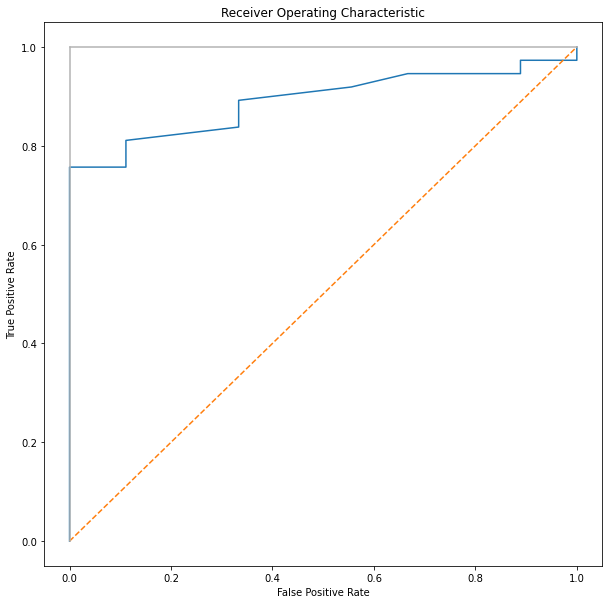

In [29]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
print('roc_auc_score:', roc_auc_score(y_test, y_score))

roc_auc_score: 0.8903903903903903
